# Traveling Salesman Computer Vision

**Kaggle Dataset**

https://www.kaggle.com/datasets/jeffheaton/traveling-salesman-computer-vision/data

In [2]:
# libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import tensorflow as tf

import PIL.Image as Image
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-05-23 00:54:23.147849: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 00:54:23.363420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 00:54:23.363514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 00:54:23.403404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 00:54:23.492679: I tensorflow/core/platform/cpu_feature_guar

In [3]:
data_path = r"./tsp-all.csv"
train_data_path = r"./train.csv"

data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)

test_data_path = r"./test.csv"
test_data = pd.read_csv(test_data_path)

### Dataset Columns Description

The columns:

- **id**: A unique ID that allows linking across all three CSV files.
- **filename**: The name of each map's image file.
- **distance**: The total distance through the cities, this is the y/label.
- **key**: The generator filename, provides the dimensions, city count, & distance.

In [5]:
data = pd.DataFrame(data)
data

,id,filename,distance,key
0,0,0.jpg,83110,503x673-270-83110.jpg
1,1,1.jpg,1035,906x222-10-1035.jpg
2,2,2.jpg,20756,810x999-299-20756.jpg
3,3,3.jpg,13286,781x717-272-13286.jpg
4,4,4.jpg,13924,609x884-312-13924.jpg
...,...,...,...,...
20018,20019,20019.jpg,7146,376x499-257-7146.jpg
20019,20020,20020.jpg,9695,403x543-348-9695.jpg
20020,20021,20021.jpg,11420,678x497-398-11420.jpg
20021,20022,20022.jpg,15570,739x605-45-15570.jpg


In [6]:
width,height,city_count = [],[],[]
def extract_info(key):
    numbers = re.findall(r'\d+', key) # Use re.findall() to find all sequences of digits
    numbers = list(map(int, numbers)) # convert the list of string numbers to a list of integers
    width.append(numbers[0])
    height.append(numbers[1])
    city_count.append(numbers[2])

for key in data['key']:
    extract_info(key)

In [7]:
data['width'] = width
data['height'] = height
data['city_count'] = city_count

In [8]:
data.describe()

,id,distance,width,height,city_count
count,20023.000000,20023.000000,20023.000000,20023.000000,20023.000000
mean,10011.430405,17788.314788,673.856465,611.027418,203.354942
std,5780.711196,25481.898805,203.361729,238.839623,114.751467
min,0.000000,337.000000,320.000000,200.000000,5.000000
25%,5005.500000,5851.000000,496.000000,405.000000,103.000000
50%,10011.000000,9533.000000,676.000000,610.000000,203.000000
75%,15017.500000,15279.000000,850.000000,820.000000,302.000000
max,20023.000000,180654.000000,1024.000000,1024.000000,999.000000


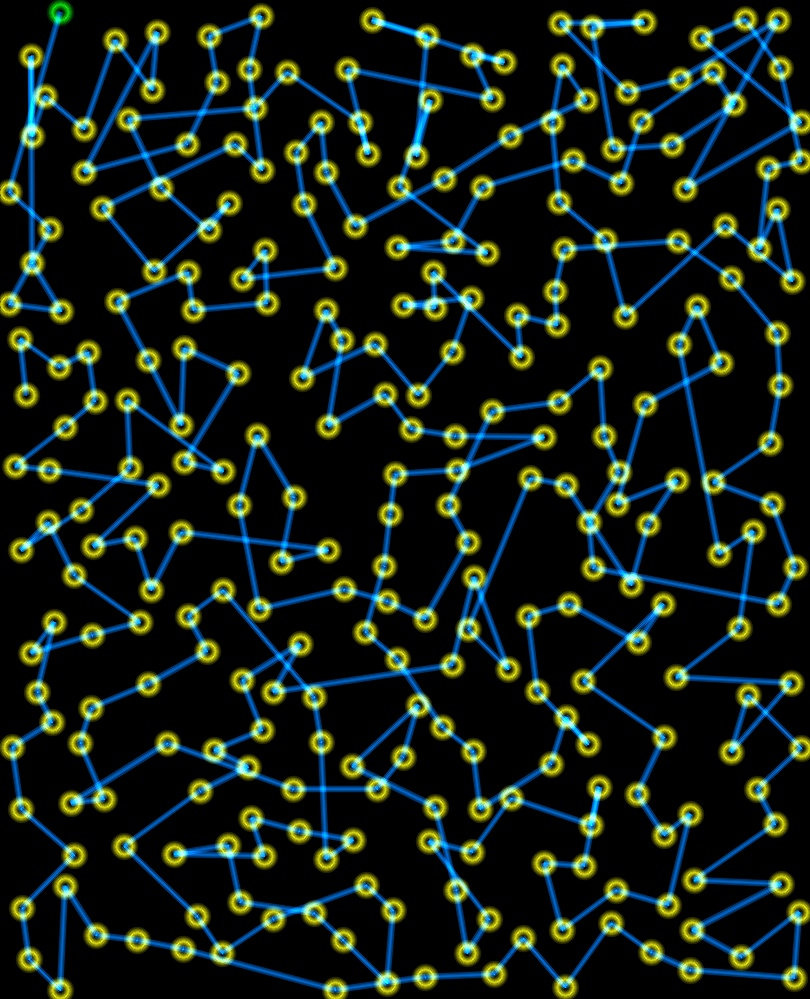

In [27]:
img_path = "./tsp-cv/2.jpg"
img = Image.open(img_path)
img

# Dataset Challenges

This is a regression problem, you are to estimate the total path length. Several challenges to consider:

- **Scaling Maps**: If you indiscriminately scale the maps, you will lose size information.
- **Overlapping Paths**: Paths might overlap, causing the ratio of total pixels to total length to become misleading.
- **Color Brightness**: As paths overlap both other path segments and cities, the resulting color becomes brighter.


## Tackle 1st Problem

**Note**: `max_size = (1024, 1024)`

We will resize all the images to maximize size by using padding. In this way, we will not lose the size information.

In [9]:
def pad_image_to_size(input_image, target_size=(1024, 1024), background_color=(0,0,0)):
    original_image = Image.open(input_image)
    original_width, original_height = original_image.size
    
    # Create a new image with the desired size and background color
    new_image = Image.new("RGB", target_size, background_color)
    
    # Calculate the position to paste the resized image onto the new image
    paste_position = ((target_size[0] - original_width) // 2, (target_size[1] - original_height) // 2)
    
    # Paste the resized image onto the center of the new image
    new_image.paste(original_image, paste_position)
    
    # final resize
    return new_image

In [10]:
def data_preprocess(dataframe):
    X = []
    for index, row in dataframe.iterrows():
        img_path = r"./tsp-cv/" + str(row['filename'])
        img = pad_image_to_size(img_path)
        img = img.resize((30,30))
        img_array = np.array(img)
        X.append(img_array)
        # # 'distance' is y/label column
        # y.append(row['distance'])
    return X

## Preprocessing Training Dataset

In [11]:
X_train = data_preprocess(train_data)

In [12]:
y_train = train_data['distance']

#### Scaling

In [13]:
X_Train = np.array(X_train) / 255
y_Train = np.array(y_train)

In [14]:
print(X_Train.shape)
print(y_Train.shape)

(16018, 30, 30, 3)
(16018,)


#### Extracting y_test from full DATA

In [15]:
test_data = data[16019:]
X_test = data_preprocess(test_data)
X_test = np.array(X_test) / 255
y_test = test_data['distance']
y_test = np.array(y_test)

In [16]:
print(X_test.shape)
print(y_test.shape)

(4004, 30, 30, 3)
(4004,)


#### Splitting X_Train into X_train1 and X_test1 (or say X_cv)

In [17]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_Train, y_Train, train_size=0.2, random_state=42)

In [18]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

## Creating CNN model

Filters will take care of overlapping paths and colour brightness

In [19]:
model = Sequential([
    # cnn
    layers.Conv2D(filters=16, activation='relu', kernel_size=(3,3), input_shape=(30,30,3)), # kernel_size is the filter size u are using
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=32, activation='relu', kernel_size=(3,3), input_shape=(30,30,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, activation='relu', kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    # ann // dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1)
])

model.compile(optimizer='adam',
            loss= keras.losses.MeanSquaredError(),
            metrics=[r2_score])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 64)          0

In [21]:
model.fit(X_train1,y_train1, epochs=15)

Epoch 1/15
101/101 [==============================] - 1s 5ms/step - loss: 716937344.0000 - r2_score: -0.2568
Epoch 2/15
101/101 [==============================] - 1s 6ms/step - loss: 216062672.0000 - r2_score: 0.6377
Epoch 3/15
101/101 [==============================] - 1s 6ms/step - loss: 170270288.0000 - r2_score: 0.6868
Epoch 4/15
101/101 [==============================] - 1s 7ms/step - loss: 145798384.0000 - r2_score: 0.7298
Epoch 5/15
101/101 [==============================] - 1s 6ms/step - loss: 134168424.0000 - r2_score: 0.7711
Epoch 6/15
101/101 [==============================] - 1s 6ms/step - loss: 133299296.0000 - r2_score: 0.7787
Epoch 7/15
101/101 [==============================] - 1s 6ms/step - loss: 122869136.0000 - r2_score: 0.7838
Epoch 8/15
101/101 [==============================] - 1s 6ms/step - loss: 101736264.0000 - r2_score: 0.8319
Epoch 9/15
101/101 [==============================] - 1s 6ms/step - loss: 100008280.0000 - r2_score: 0.8160
Epoch 10/15
101/101 [======

# Results

In [22]:
model.evaluate(X_test1, y_test1)

401/401 [==============================] - 1s 2ms/step - loss: 20005972.0000 - r2_score: 0.9578


[20005972.0, 0.9577966928482056]

### Final Result

In [23]:
model.evaluate(X_test,y_test)

126/126 [==============================] - 0s 3ms/step - loss: 20503218.0000 - r2_score: 0.9416


[20503218.0, 0.9415963888168335]

In [24]:
y_pred = model.predict(X_test)
results = pd.DataFrame()
results['y_test'] = pd.DataFrame(y_test)
results['y_pred'] = y_pred
results

126/126 [==============================] - 0s 2ms/step


,y_test,y_pred
0,55783,61975.039062
1,11487,9396.901367
2,8077,9376.086914
3,16592,15748.583008
4,6399,5615.977539
...,...,...
3999,7146,5764.490234
4000,9695,10463.641602
4001,11420,10962.916992
4002,15570,22078.984375


## Plots

Text(0.5, 1.0, 'Scatter plot of Test Dataset')

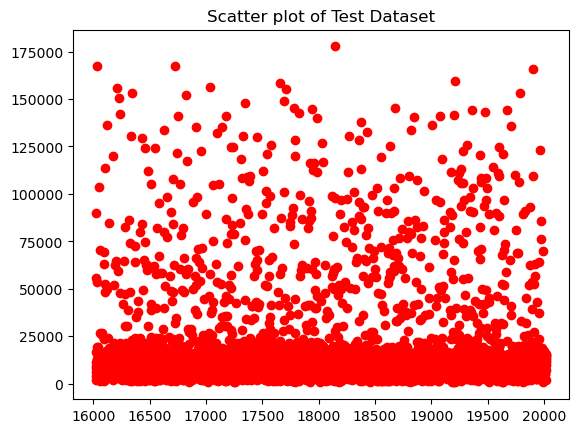

In [29]:
plt.scatter(test_data['id'], y_test, color='red')
plt.title("Scatter plot of Test Dataset")

Text(0.5, 1.0, 'Scatter plot of Prediction')

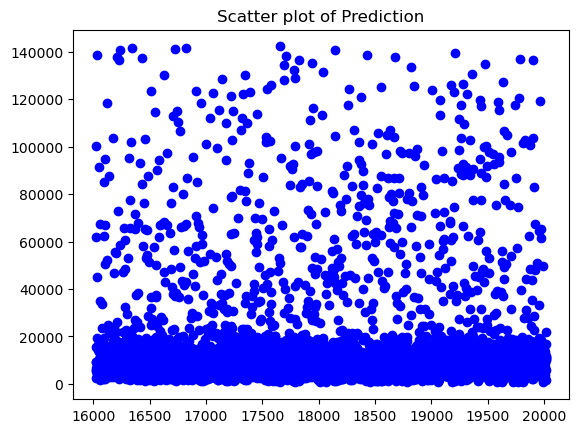

In [30]:
plt.scatter(test_data['id'], y_pred, color='blue')
plt.title("Scatter plot of Prediction")

Text(0.5, 1.0, 'Together')

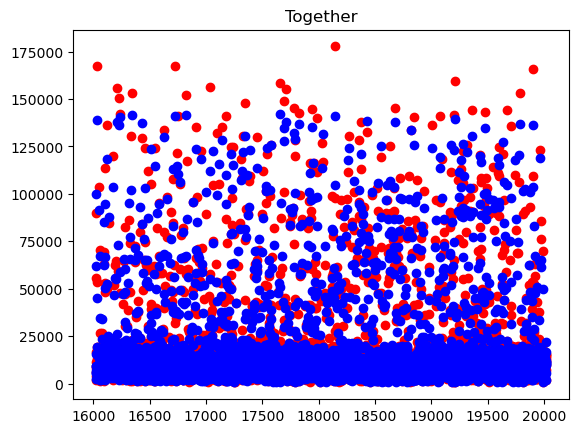

In [31]:
plt.scatter(test_data['id'], y_test, color='red')
plt.scatter(test_data['id'], y_pred, color='blue')
plt.title("Together")

In [36]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(y_test, y_pred, color='red')
    plt.plot(range(my_range), range(my_range), 'o')
    plt.title(regressorName)
    plt.show()
    return

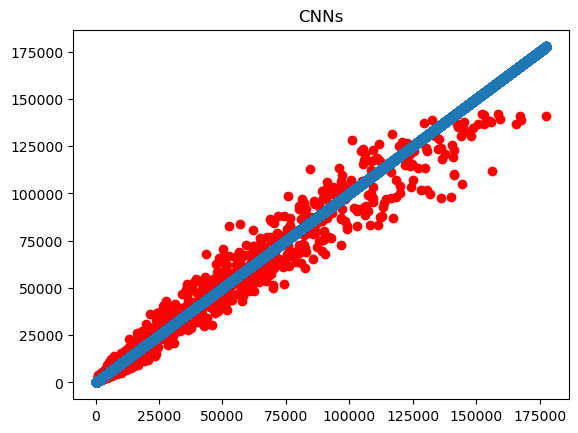

In [37]:
plotGraph(y_test, y_pred, "CNNs")